'''
Notebook http://htmlpreview.github.io/?https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.html
Reference data - github repo download (example folder) https://github.com/aertslab/SCENICprotocol
 - allTFs_hg.txt : transcript list
 - .loom : expression matrix
 - genome-ranking.feather : gene list
 - motifs.tbl : sequence motif
Dataset 

1) filtering which change in a similar way to transcript factor's expression
2) finding out which hold binding motifs in front of that
3) finally weeding out relative cells
'''

In [ ]:
!pip install pyscenic

In [1]:
!pip install loompy

In [2]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE

In [4]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "/home/mohyelim7/scRNAseq"
os.chdir( wdir )

# path to unfiltered loom file (this will be created in the optional steps below)
f_loom_path_unfilt = "autism_unfiltered.loom" # test dataset

# path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "autism_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "./write/autism_pySCENIC.h5ad"

# path to pyscenic output
f_pyscenic_output = "pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'autism_scenic_integrated-output.loom'

In [5]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.4
-----
MulticoreTSNE       NA
PIL                 8.0.1
backcall            0.2.0
bottleneck          1.3.2
cffi                1.14.3
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2.30.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.2
h5py                2.10.0
igraph              0.9.4
ipykernel           5.3.4
ipython_ge

In [6]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

# Expression data import

In [7]:
f_mtx_dir = '/data/mohyelim7/scRNAseq/rawMatrix'

adata = sc.read_10x_mtx(
    f_mtx_dir ,                 # the directory with the `.mtx` file
    var_names='gene_symbols',   # use gene symbols for the variable names (variables-axis index)
    cache=False) 

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
/home/mohyelim7/anaconda3/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [ ]:
# f_exprMat = '/data/mohyelim7/scRNAseq/exprMatrix.tsv.gz'

# adata = sc.read_text( f_exprMat, delimiter='\t', first_column_names=True )

In [ ]:
# ad = adata

# adata = ad.transpose()
# genes = pd.read_csv("/data/mohyelim7/scRNAseq/rawMatrix/genes.tsv", sep="\t", names=["gene_ids", "gene_names"])

# def tsvToDic(dir_path):
#     dic = {}
#     with open(dir_path+"/genes.tsv") as f:
#         for line in f:
#             key, value = line.split("\t")
#             dic[key]=value.strip()
#     return dic

# genes_dic = tsvToDic("/data/mohyelim7/scRNAseq/rawMatrix")

# df_id = pd.DataFrame({'gene_id' : list(adata.var_names)})

# df_id.replace(to_replace=genes_dic, inplace=True)

# adata.var.index = df_id['gene_id']

# adata.var_names

In [8]:
adata

AnnData object with n_obs × n_vars = 104559 × 65217
    var: 'gene_ids'

In [ ]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [9]:
''' making loom file ''' 

row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

# Initial/basic filtering

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# read unfiltered data from a loom file
adata = sc.read_loom( f_loom_path_unfilt )

In [12]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  32212392.0
Number of cells in which each gene is detected: 0  -  104067


In [13]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  3136.77
minSamples:  1045.59


In [14]:
adata.X

<104559x65217 sparse matrix of type '<class 'numpy.float32'>'
	with 238268142 stored elements in Compressed Sparse Row format>

In [15]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/home/mohyelim7/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohyelim7/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohyelim7/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

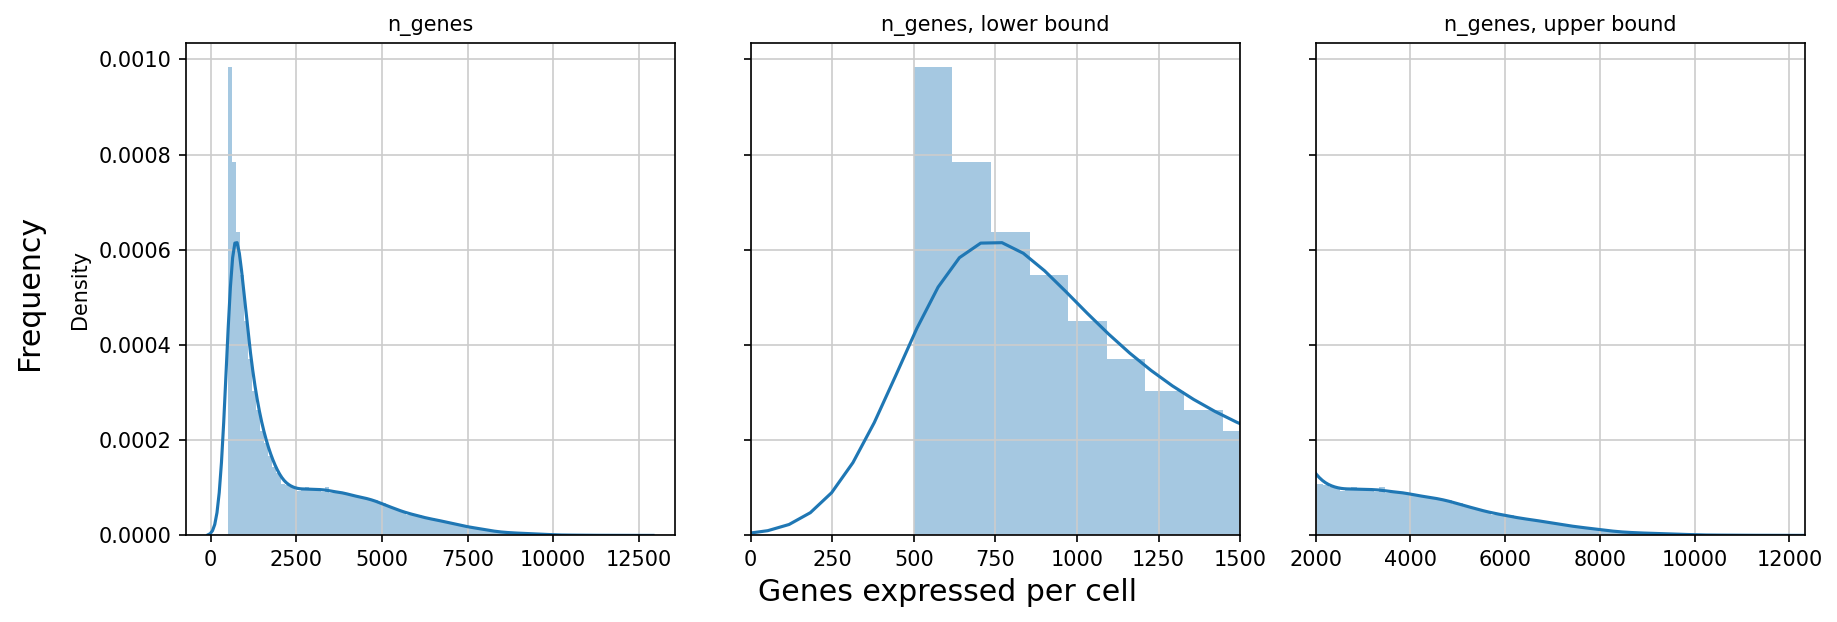

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

/home/mohyelim7/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohyelim7/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohyelim7/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

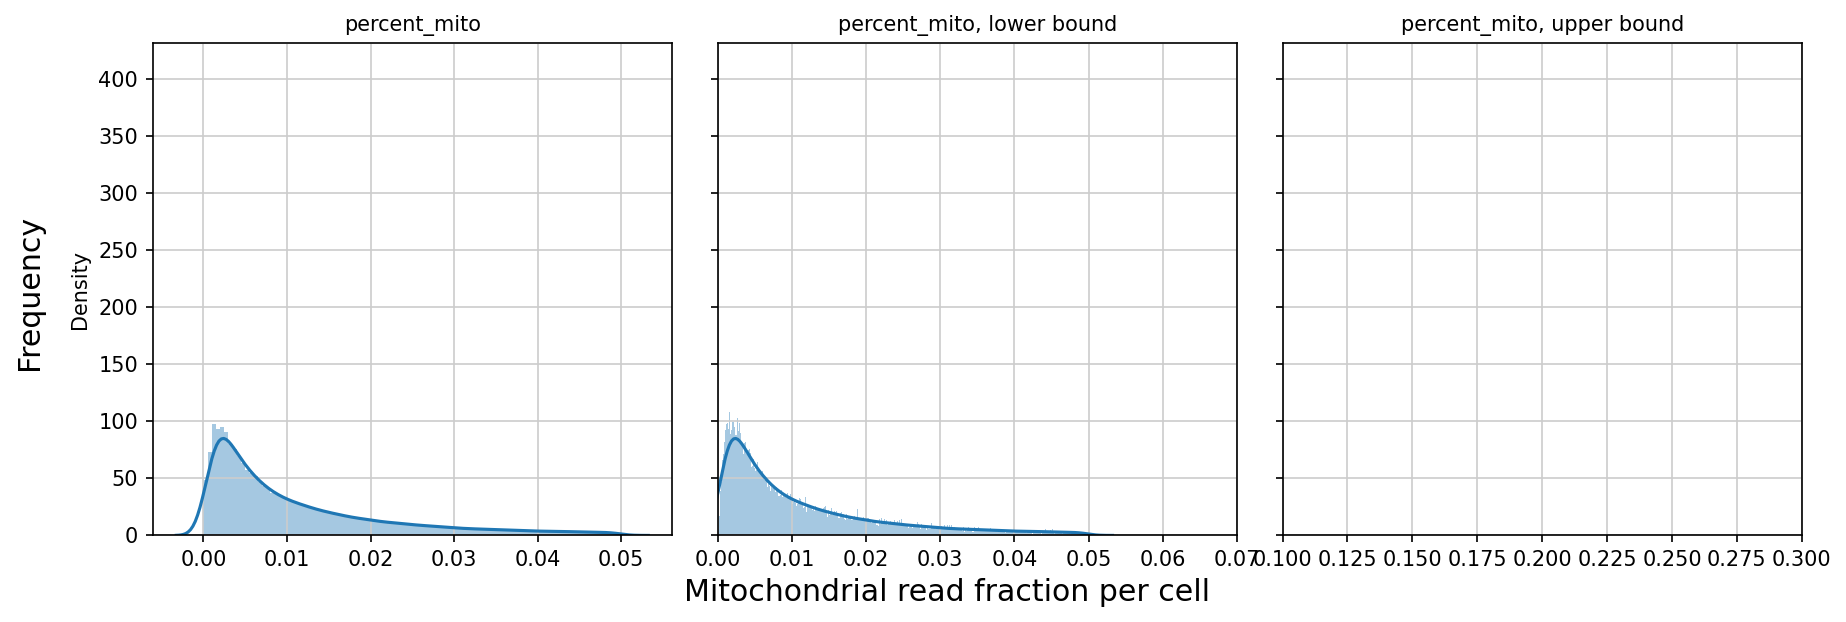

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

/home/mohyelim7/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohyelim7/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohyelim7/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

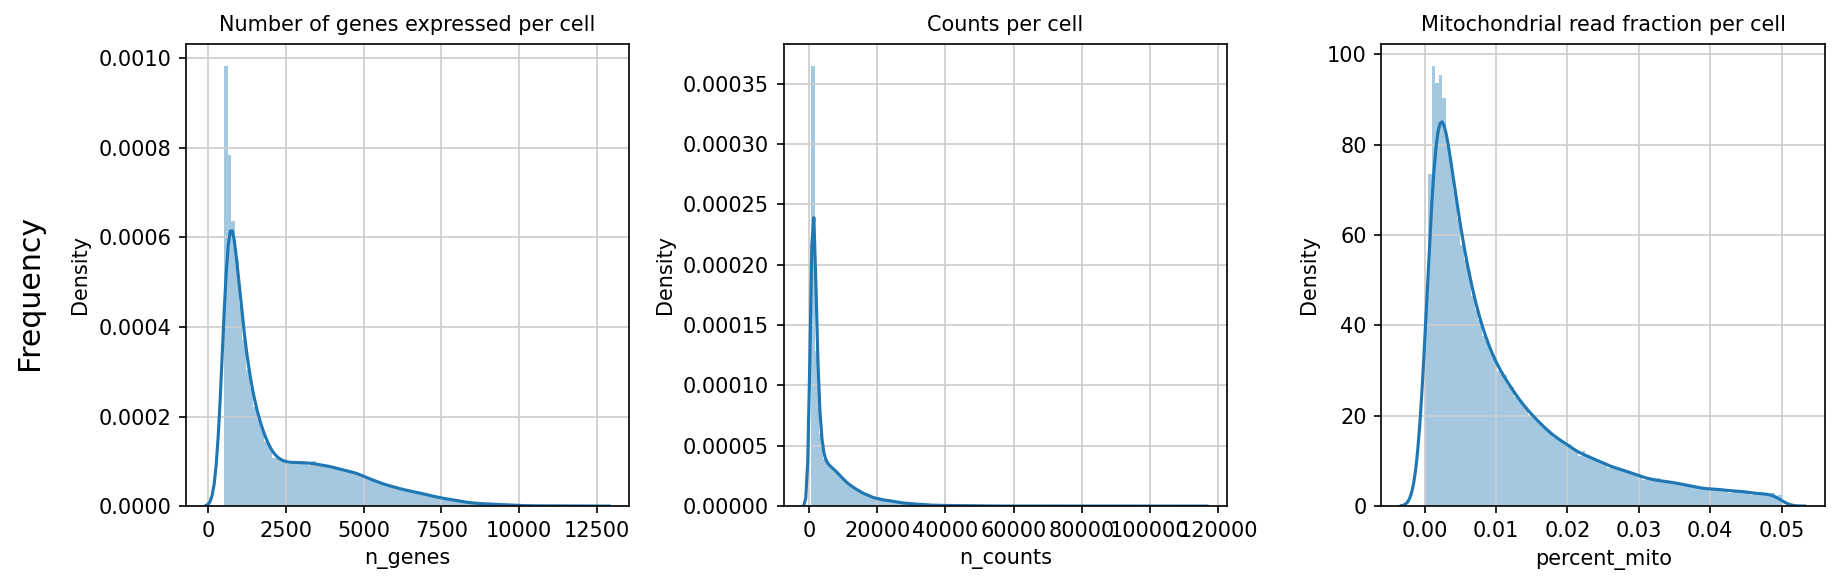

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_prefilter.pdf', dpi=600, bbox_inches='tight')

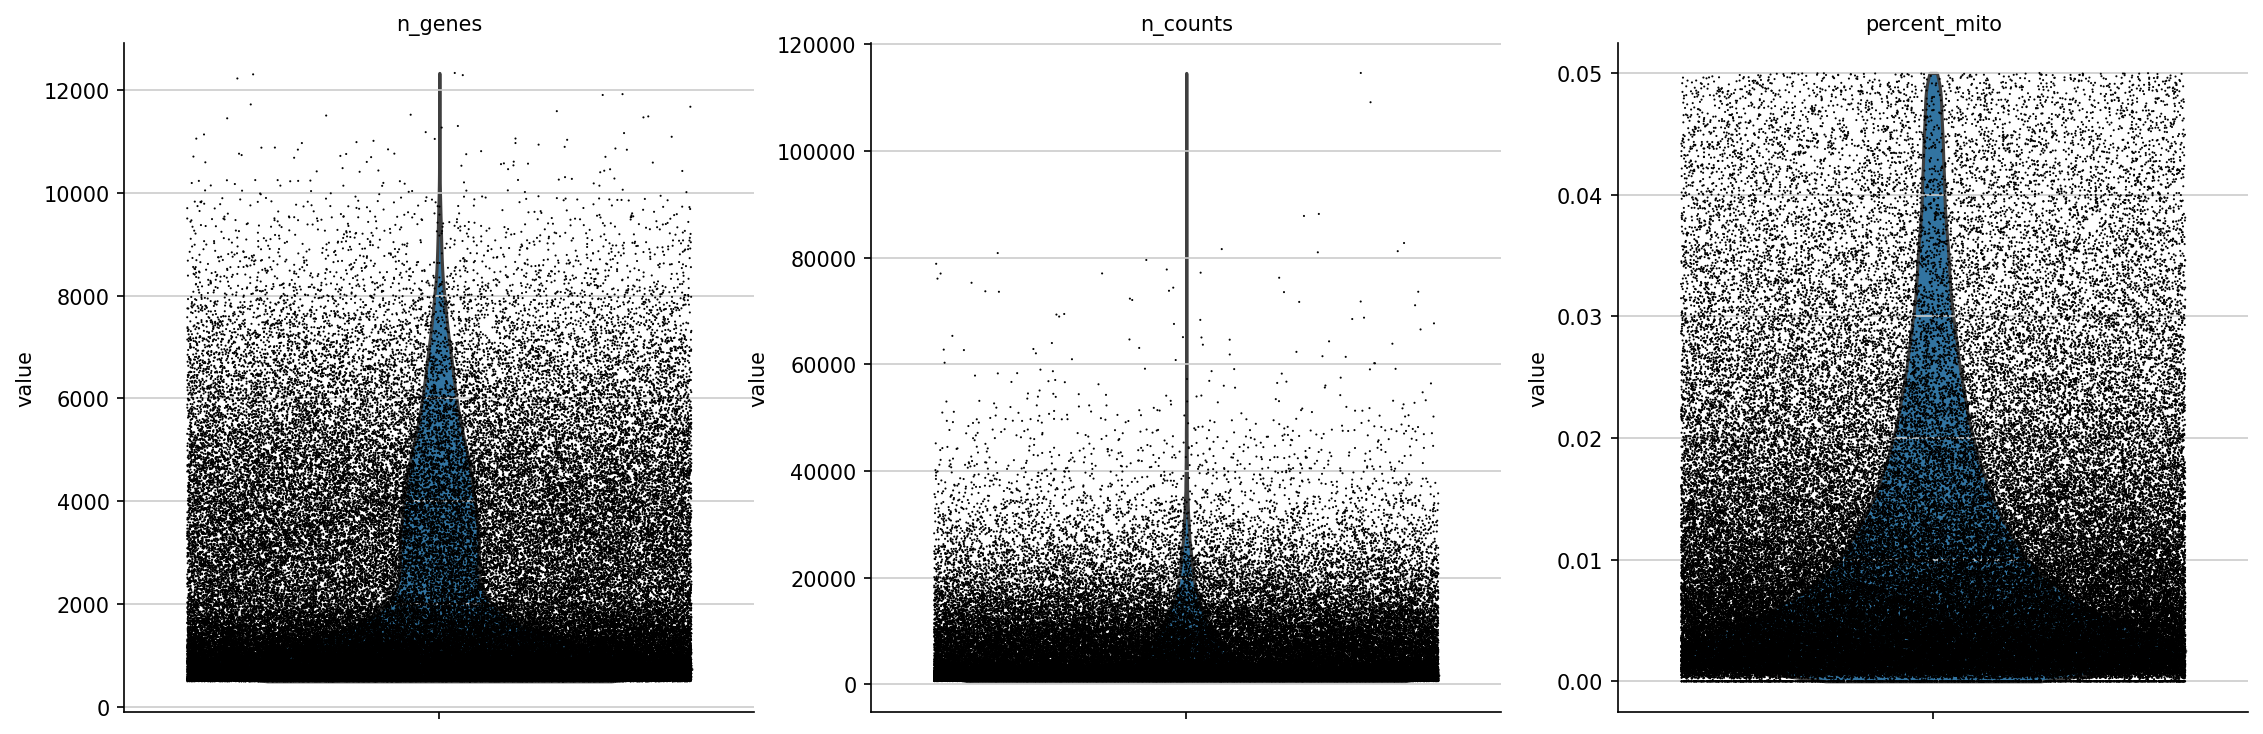

In [19]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

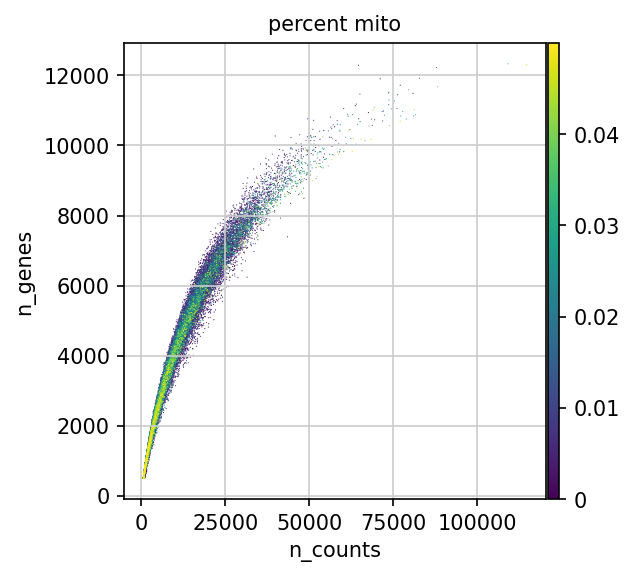

In [20]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [21]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 27254 genes that are detected in less than 3 cells


In [22]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

/home/mohyelim7/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohyelim7/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohyelim7/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

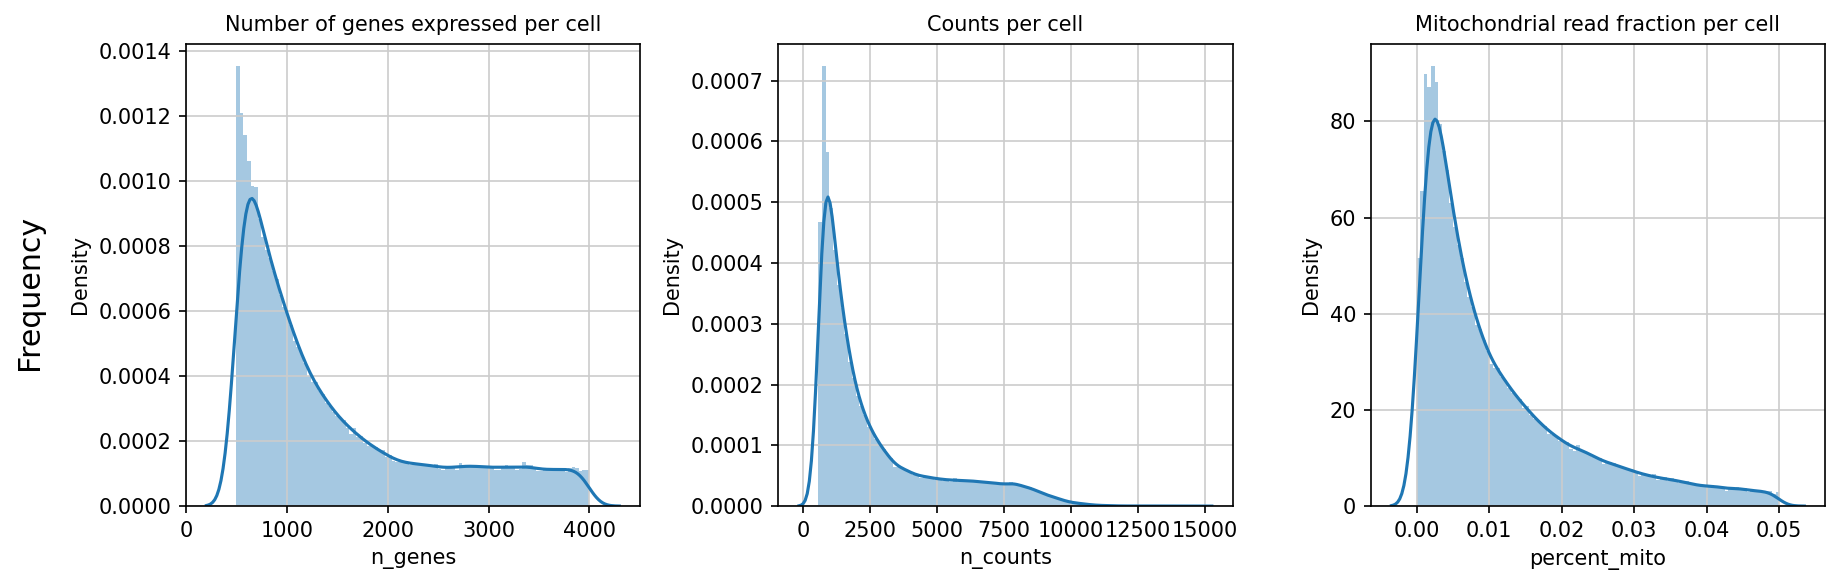

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_postfilter.pdf', dpi=600, bbox_inches='tight')

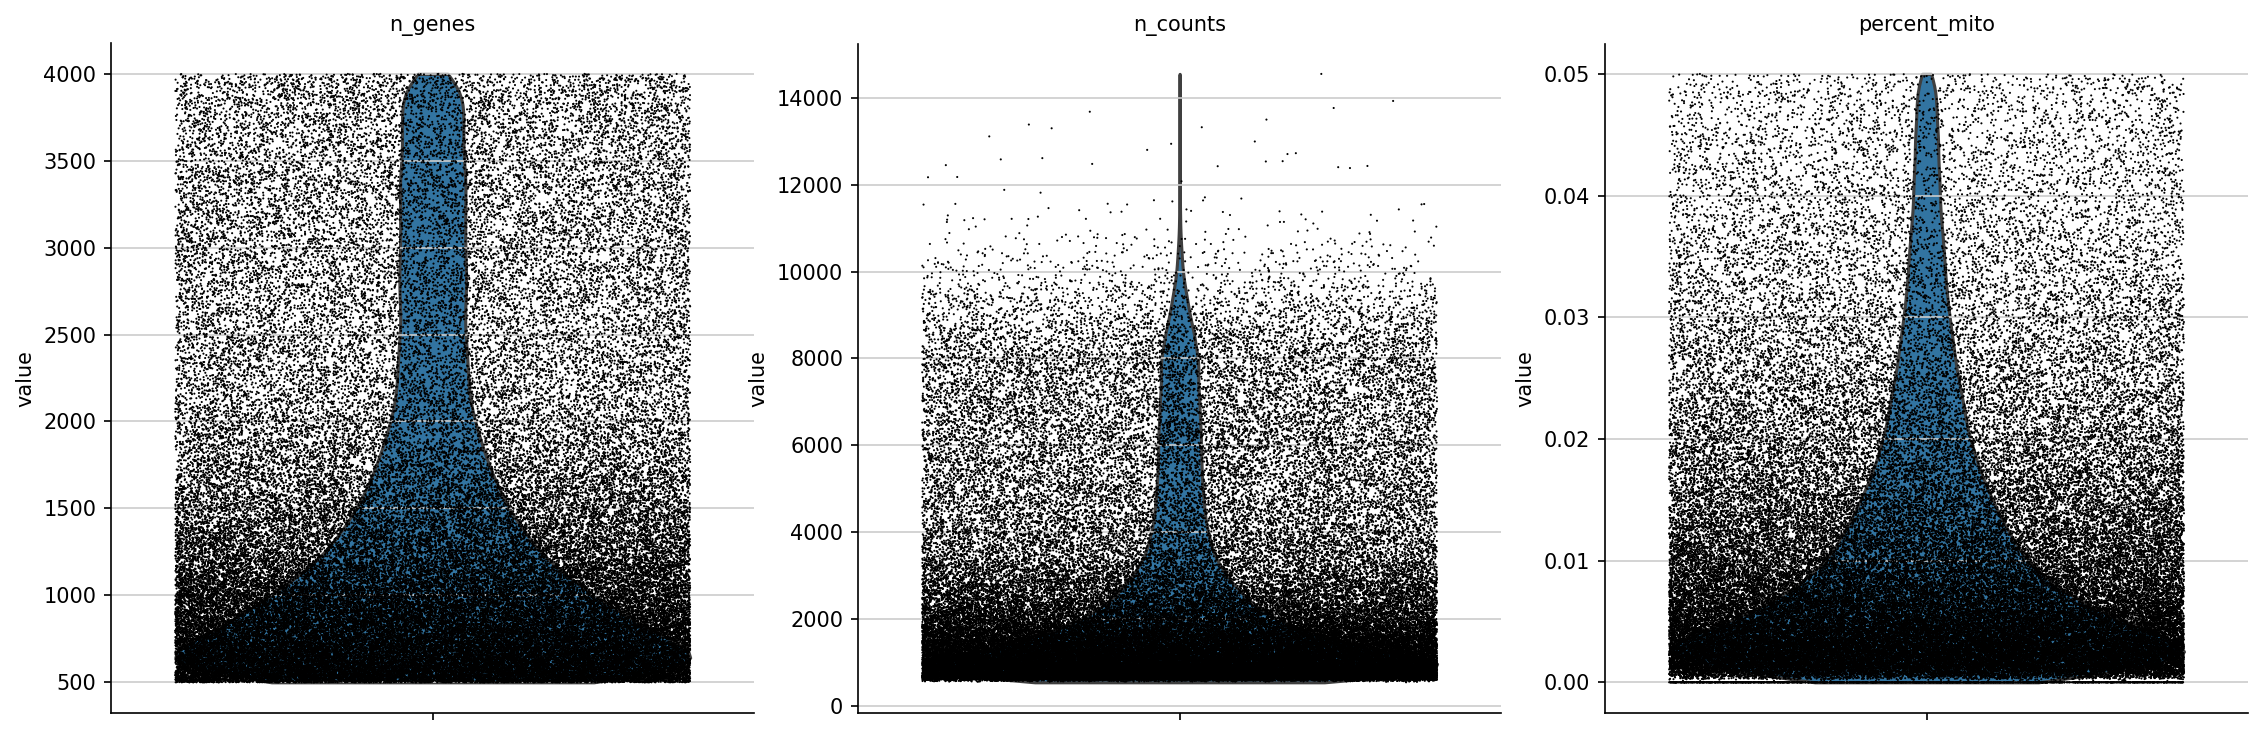

In [24]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

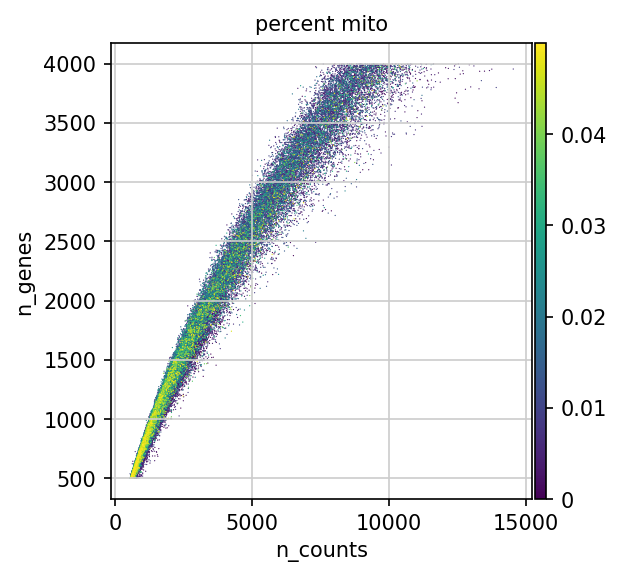

In [25]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [26]:
adata.write( f_anndata_path )

In [27]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


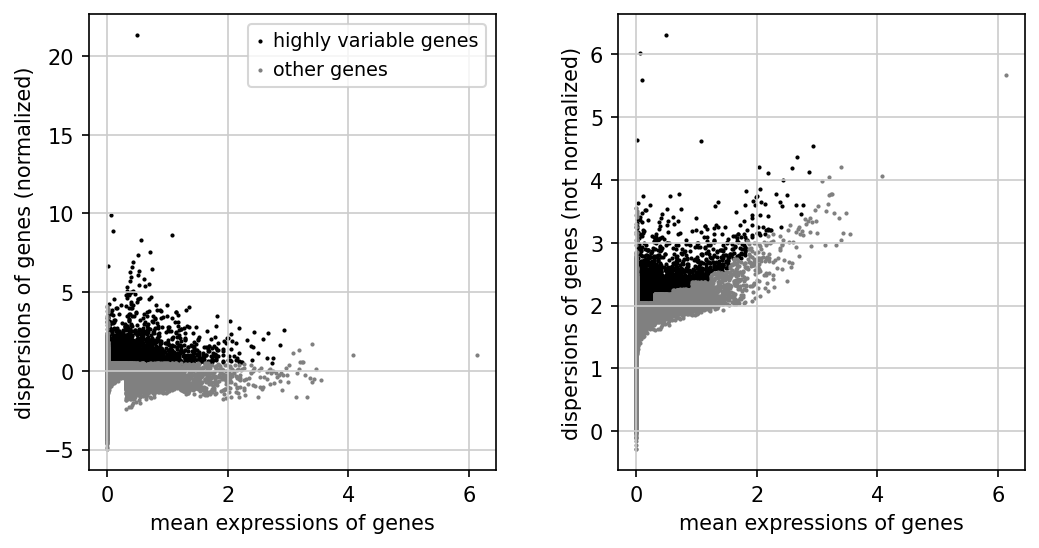

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:03:43)


In [29]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

# update the anndata file:
adata.write( f_anndata_path )

## 1. PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:22)


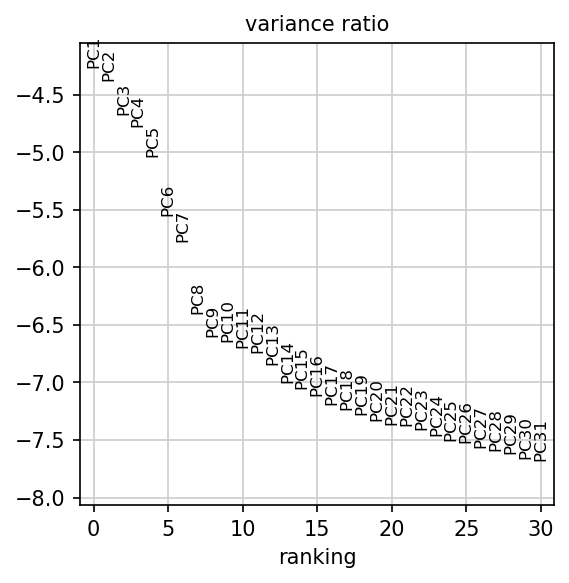

In [30]:
# adata = sc.read_h5ad( f_anndata_path )
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write( f_anndata_path )

## 2. Visualization of highly variable genes

In [31]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=323, n_pcs=15)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path )

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:46)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:43)


## 3. Clustering

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:03:42)


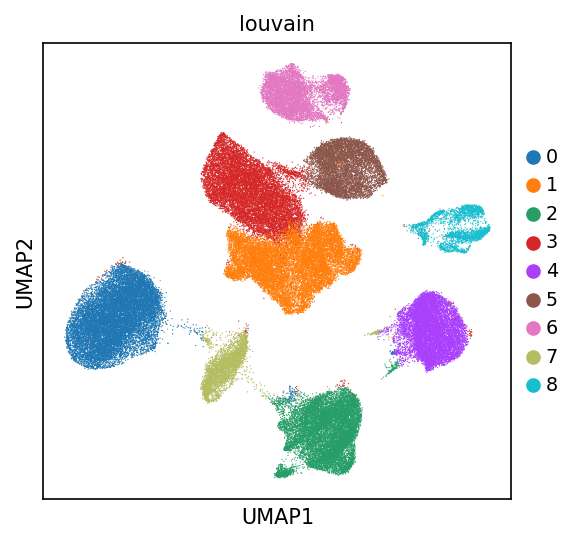

In [32]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.4)

sc.pl.umap(adata, color=['louvain'] )

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


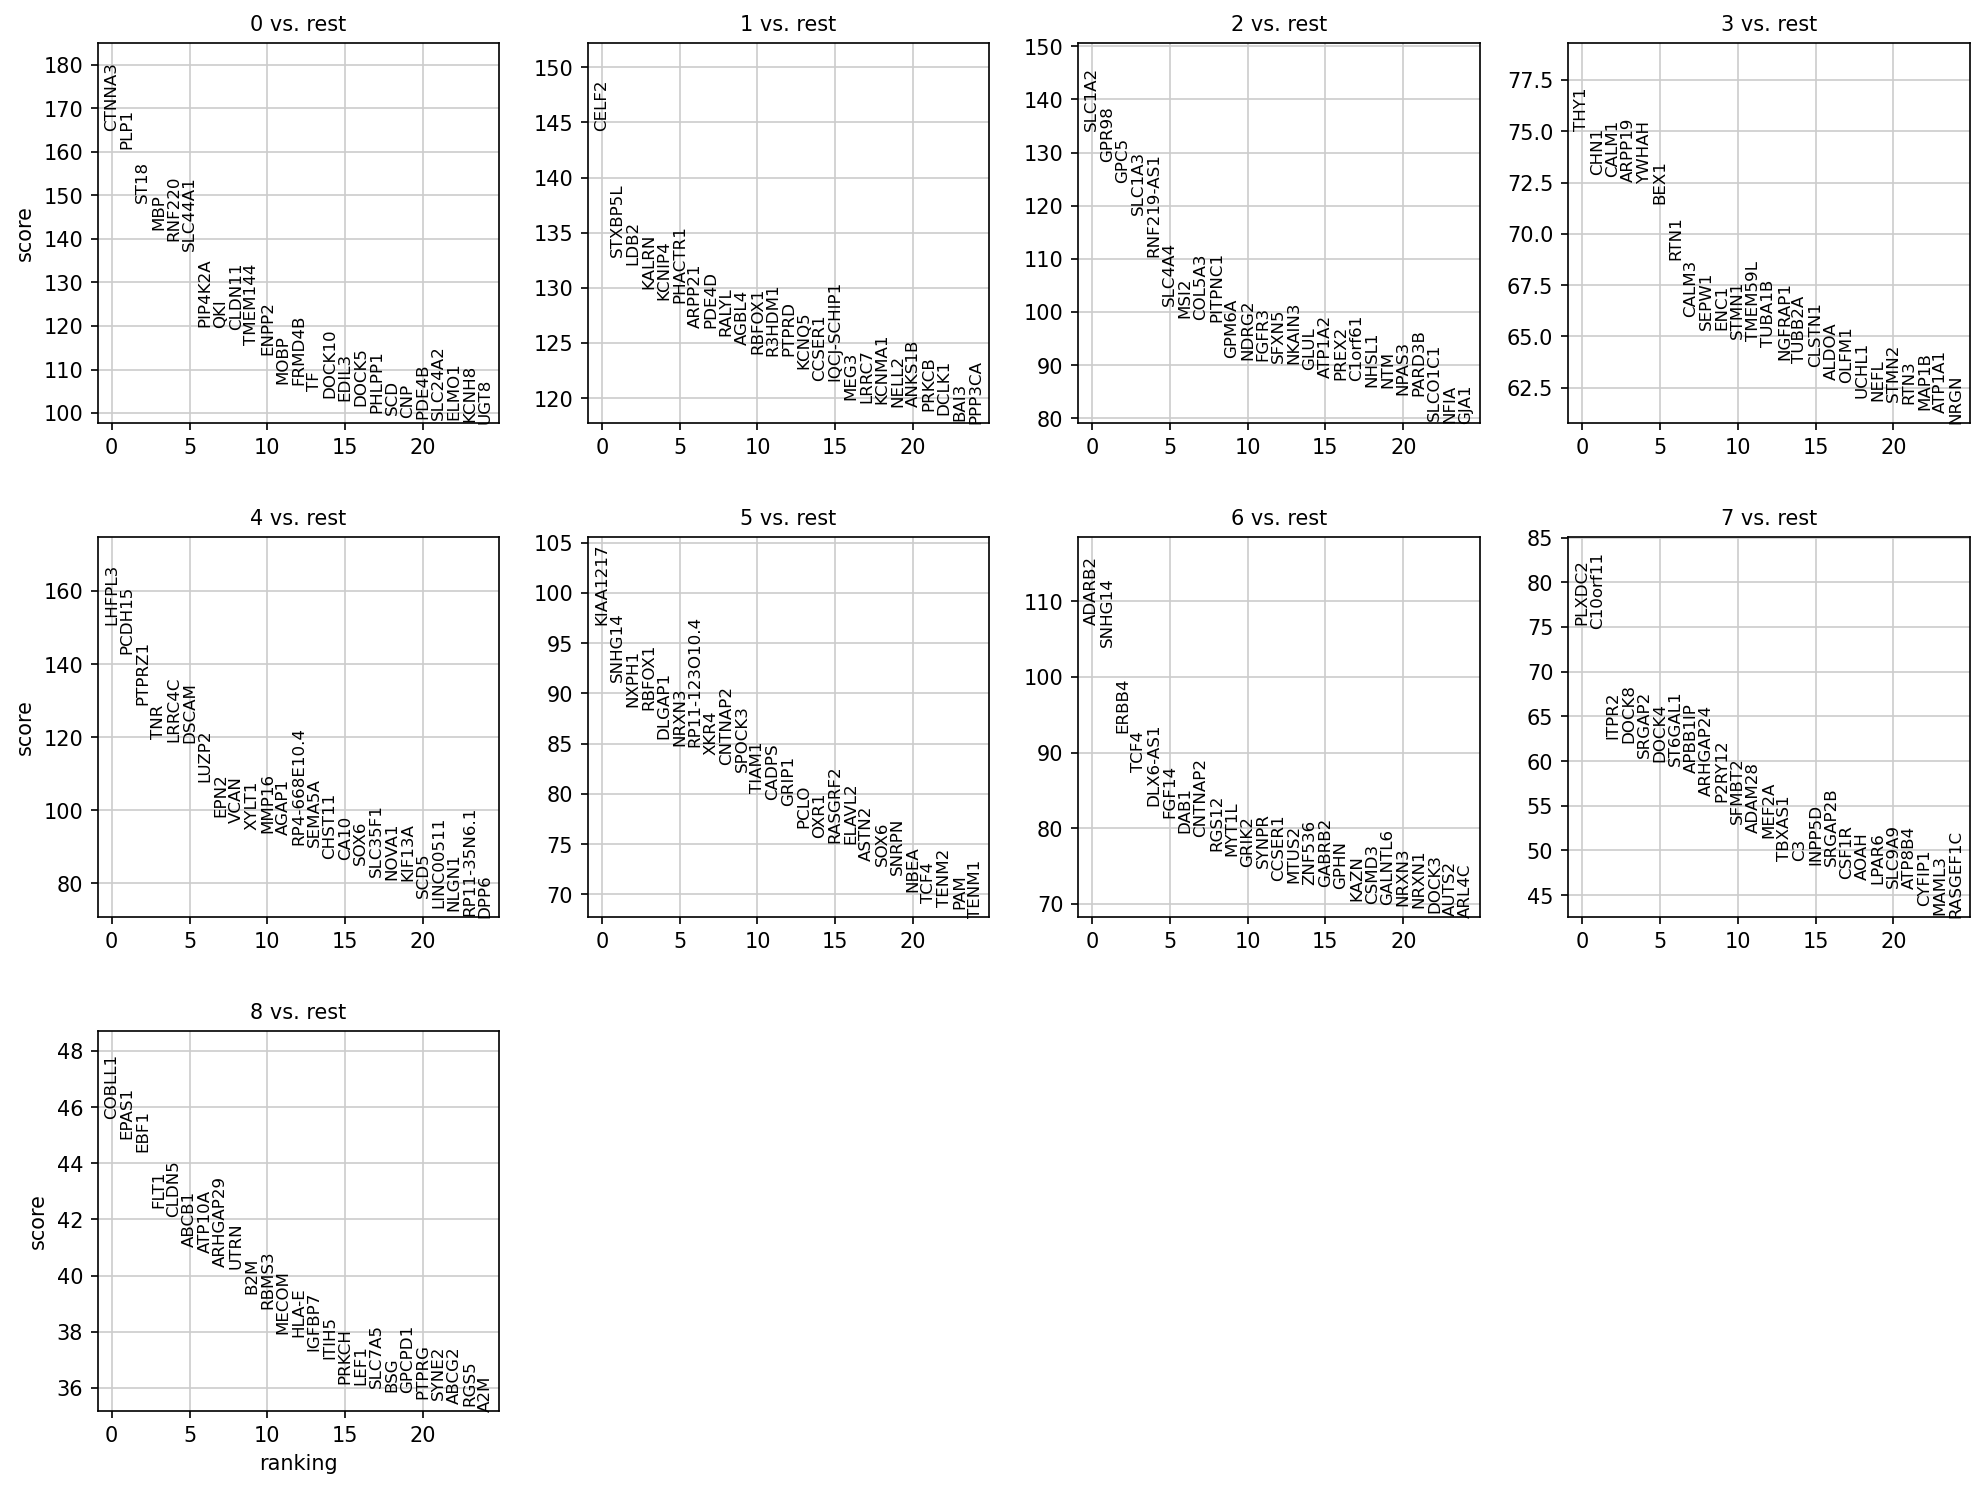

In [33]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write( f_anndata_path )

# SCENIC steps

'''
command : grn -> ctx -> aucell
'''

## STEP 1: Gene regulatory network inference, and generation of co-expression modules

In [34]:
# transcription factors list
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_hg38.txt" # human
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_dmel.txt" # drosophila
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_mm.txt"   # mouse
# tf_names = load_tf_names( f_tfs )

f_tfs = "/data/mohyelim7/scRNAseq/SCENICprotocol/example/allTFs_hg38.txt" # human

In [45]:
!pip install pyscenic

  Using cached pyscenic-0.11.2-py3-none-any.whl (7.1 MB)
  Using cached arboreto-0.1.6-py2.py3-none-any.whl (15 kB)
     |████████████████████████████████| 1.5 MB 2.5 MB/s eta 0:00:01
  Using cached multiprocessing_on_dill-3.5.0a4.tar.gz (53 kB)
  Using cached boltons-21.0.0-py2.py3-none-any.whl (193 kB)
  Using cached ctxcore-0.1.1-py3-none-any.whl (5.6 MB)
  Using cached frozendict-2.0.2-py3-none-any.whl (8.3 kB)
  Using cached interlap-0.2.7.tar.gz (6.1 kB)
  Using cached async_timeout-3.0.1-py3-none-any.whl (8.2 kB)
     |████████████████████████████████| 159 kB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 324 kB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 3.0 MB/s eta 0:00:011
     |████████████████████████████████| 63.2 MB 5.1 MB/s eta 0:00:01
  Created wheel for multiprocessing-on-dill: filename=multiprocessing_on_dill-3.5.0a4-py3-none-any.whl size=64301 sha256=2899c1cc63e462928c1e0e0cc052928ee4fc12e60d46ef0f2085d64efd86c963
  Stored in dir

In [47]:
!pyscenic grn /home/mohyelim7/scRNAseq/autism_filtered_scenic.loom /data/mohyelim7/scRNAseq/SCENICprotocol/example/allTFs_hg38.txt -o adj.csv --num_workers 30


2021-06-14 20:37:01,540 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2021-06-14 20:37:24,418 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
/home/mohyelim7/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42359 instead
  warnings.warn(
preparing dask client
parsing input
creating dask graph
30 partitions
computing dask graph
distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:46447
Traceback (most recent call last):
  File "/home/mohyelim7/anaconda3/lib/python3.8/site-packages/distributed/comm/core.py", line 319, in connect
    handshake = await asyncio.wait_for(comm.read(), time_left())
  File "/home/mohyelim7/anaconda3/lib/python3.8/asyncio/tasks.py", line 490, in wait_for
    raise exceptions.TimeoutError()
asyncio.exceptions.TimeoutError

The above exception was the direct cause of the

In [48]:
adjacencies = pd.read_csv("adj.tsv", index_col=False, sep='\t')

FileNotFoundError: [Errno 2] No such file or directory: 'adj.tsv'

In [ ]:
adjacencies.head()

'''
TF regulate target gene with importance value weight
'''

## STEP 2-3: Regulon prediction aka cisTarget from CLI

In [ ]:
import glob
# ranking databases
# f_db_glob = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/*feather"
# f_db_names = ' '.join( glob.glob(f_db_glob) )
f_db_glob = "/data/mohyelim7/scRNAseq/SCENICprotocol/example/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
#f_motif_path = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"
f_motif_path = "/data/mohyelim7/scRNAseq/SCENICprotocol/example//motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [ ]:
!pyscenic ctx adj.tsv \
    data/mohyelim7/scRNAseq/SCENICprotocol/example/geonome-ranking.feather \
    --annotations_fname data/mohyelim7/scRNAseq/SCENICprotocol/example/modifs.tbl \
    --expression_mtx_fname data/mohyelim7/scRNAseq/SCENICprotocol/example/autism_filtered_scenic.loom \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 30

## STEP 4: Cellular enrichment (aka AUCell) from CLI

In [ ]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [ ]:
!pyscenic aucell \
    "home/mohyelim7/scRNAseq/autism_filtered_scenic.loom" \
    reg.csv \
    --output "home/mohyelim7/scRNAseq/pyscenic_output.loom" \
    --num_workers 30

In [ ]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( "home/mohyelim7/scRNAseq/pyscenic_output.loom", mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [ ]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')